A quick tutoial using agnvar. We will be using the agnsed mode (AGNsed_var), comprising of an outer standard disc (i.e multi-colour black-body), followed by a warm Comptonizing region, and then the hot Comptonizing corona. See Kubota & Done (2018) for details on the SED model.

In [60]:
#Generic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cols

#Adding src directory to python path - needed as agnvar uses pyNTHCOMP, this is easiest way of NOT breaking code...
import os
import sys
sys.path.append(os.path.abspath('src'))

#Doing example with AGNsed_var (as my preffered model) - however the syntex is same for the others too
from agnvar import AGNsed_var

In [61]:
#Defining accretion params
M = 1e8 #BH mass, Msol
D = 100 #Distance, co-moving, Mpc
log_mdot = -1.2 #log mass accretion rate, in Eddington units (Mdot/Mdot_edd)
a_star = 0.7 #BH spin, dimensionless
cosi = 0.9 #cos inclination, measured from z-axis (disc in x-y plane)
kTe_h = 100 #electron temp of hot Comptonizing region, keV
kTe_w = 0.2 #electron temp of warm Comptonizing region, keV
gamma_h = 1.7 #Photon index of hot Comptonizing region
gamma_w = 2.7 #Photon index of warm Comptonizing region
r_h = 10 #Outer radius of corona, Rg
r_w = 50 #Outer radius of warm Comptonizing region, Rg
log_rout = 5 #log of outer disc radius, Rg
hmax = 10 #max height of corona - used to set lamppost height for irradiation approx. Rg
z = 0.025 #Redshift at D for whatever cosmology you are assuming

There are a couple of switching parameters here. If you set log_rout = -1, then it will use the self-gravity radius from Laor & Netzer (1989) assuming viscous param \alpha=0.1

If you set r_h or r_w = -1, then it will use the innermost stable circular orbit, r_isco.

If r_w > r_out, then it re-sets to r_w = r_out

In [65]:
#Now initiating the model object
agnmod = AGNsed_var(M, D, log_mdot, a_star, cosi, kTe_h, kTe_w, gamma_h, gamma_w, r_h, r_w, log_rout, hmax, z)
agnmod.new_ear(np.geomspace(1e-5, 1e3, 1000))

agnmod.set_counts()
agnmod.set_flux() #Telling model I want the SED units in photons/s/cm^2/keV



9756.097560975611


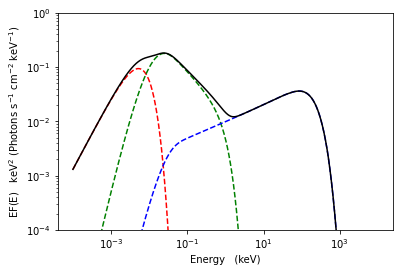

In [66]:
#As a start, we'll extract time-averaged SED
Es = agnmod.E_obs #Observed energy (redshift now taken into account)
ftot = agnmod.mean_spec() #Total SED

fd = agnmod.Lnu_d #Disc component of SED. SED components are added as properties AFTER calling .mean_spec()
fw = agnmod.Lnu_w #Warm Compton component
fh = agnmod.Lnu_h #hot Compton component

#Plotting
plt.loglog(Es, Es**2 * fd, ls='dashed', color='red')
plt.loglog(Es, Es**2 * fw, ls='dashed', color='green')
plt.loglog(Es, Es**2 * fh, ls='dashed', color='blue')

plt.loglog(Es, Es**2 * ftot, color='k')

plt.ylim(1e-4, 1)
plt.xlabel('Energy   (keV)')
plt.ylabel(r'EF(E)   keV$^{2}$ (Photons s$^{-1}$ cm$^{-2}$ keV$^{-1}$)')
plt.show()

We'll now go onto exploring the system response to a breif X-ray flash. To do this we'll simply give it a flat X-ray light-curve, modulated with a narrow Gaussian.
If you wanted to use the code to create response function, you would do something like this

In [22]:
#Defining the gaussian flash
def G_flash(t):
    tmid = 0.5 #Time for flash peak
    sigma = 0.15 #flash width (ish)
    return 1 * np.exp(-((t - tmid)**2 /( 2 * sigma**2)))

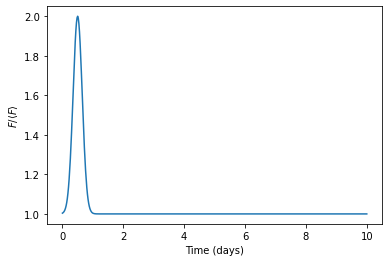

In [23]:
#Generating input x-ray light-curve
ts = np.linspace(0, 10, 500) #time-steps (DAYS!)
fx_in = G_flash(ts) + 1 #liht-cruves normalized by mean, so 1 implies NO modulation

#Plotting input
plt.plot(ts, fx_in)
plt.xlabel('Time (days)')
plt.ylabel(r'$F/\langle F \rangle$')
plt.show()

In [24]:
#Now calculating response thorughout the SED - Note this may take a couple of mins
allSEDs = agnmod.evolve_spec(fx_in, ts)
print('Completed')

Completed


The output from this will be a 2D numpy array, with shape (len(Es), len(ts)). So each column within the array contains the SED at time t

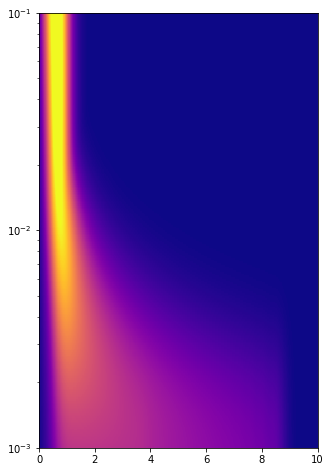

In [32]:
resp_sed = allSEDs/ftot[:, np.newaxis] #Normalising by the time-averaged SED. So units F/Fmean

#Plotting figure
fig_tsed = plt.figure(figsize=(5, 8))
ax = fig_tsed.add_subplot(111)

Eall = np.tile(Es, (len(ts), 1))
Eall = np.transpose(Eall)
tall = np.tile(ts, (len(Es), 1))

normc = cols.PowerNorm(0.3, 1, 1.1)
pcm = ax.pcolormesh(tall, Eall, resp_sed, cmap='plasma', norm=normc, shading='auto')

ax.set_yscale('log')
ax.set_ylim(1e-3, 1e-1)
plt.show()